In [181]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import os
import math
import json
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [183]:
def __save_model(model_name, model, root):
    if not os.path.isdir(root):
        os.mkdir(root)
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    torch.save(model.state_dict(), p)
    return p

def save_model(models, root='./model'):
    p = {}
    for k, m in models.items():
        p[k] = __save_model(k, m, root)
    return p

def save_model_by_score(models, bleu_score, root):
    p = os.path.join(root, 'score.json')
    previous = None
    
    if np.isnan(bleu_score):
        raise AttributeError("BLEU score become {}".format(bleu_score))
        return
    
    if os.path.isfile(p):
        with open(p, 'r') as f:
            previous = json.load(f)
            
    if previous is not None and previous['score'] > bleu_score:
        return;
    
    save_model(models, root)
    previous = {'score' : bleu_score}
    with open(p, 'w') as f:
        json.dump(previous, f)
def __load_model(model_name, model, root):
    p = os.path.join(root, '{}-params.pkl'.format(model_name))
    if not os.path.isfile(p):
        raise AttributeError(msg)
    paras = torch.load(p)
    model.load_state_dict(paras)

def load_model(models, root='./model'):
    for k, m in models.items():
        __load_model(k, m, root)
        


In [184]:
class CharDict:
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.n_words = 0
        
        for i in range(26):
            self.addWord(chr(ord('a') + i))
        
        tokens = ["SOS", "EOS"]
        for t in tokens:
            self.addWord(t)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def longtensorFromString(self, s):
        s = ["SOS"] + list(s) + ["EOS"]
        return torch.LongTensor([self.word2index[ch] for ch in s])
    
    def stringFromLongtensor(self, l, show_token=False, check_end=True):
        s = ""
        for i in l:
            ch = self.index2word[i.item()]
            if len(ch) > 1:
                if show_token:
                    __ch = "<{}>".format(ch)
                else:
                    __ch = ""
            else:
                __ch = ch
            s += __ch
            if check_end and ch == "EOS":
                break
        return s

class wordsDataset(Dataset):
    def __init__(self, train=True):
        if train:
            f = './train.txt'
        else:
            f = './test.txt'
        self.datas = np.genfromtxt(f,invalid_raise = False,dtype=np.str)
        print(self.datas)
        
        if train:
            self.datas = self.datas.reshape(-1)
        else:
            self.targets = np.array([ [0, 3], [0, 2], [0, 1], [0, 1], [3, 1], [0, 2], 
                                     [3, 0], [2, 0], [2, 3], [2, 1],])
        self.tenses = [
            'simple-present', 
            'third-person', 
            'present-progressive', 
            'simple-past'
        ]
        self.chardict = CharDict()
        
        self.train = train
    
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, index):
        if self.train:
            c = index % len(self.tenses)
            return self.chardict.longtensorFromString(self.datas[index]), c
        else:
            i = self.chardict.longtensorFromString(self.datas[index, 0])
            ci = self.targets[index, 0]
            o = self.chardict.longtensorFromString(self.datas[index, 1])
            co = self.targets[index, 1]
            return i, ci, o, co

# Encoder and Decoder

In [185]:
#Encoder
class EncoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, 
        num_condition, condition_size
    ):
        super(EncoderRNN, self).__init__()
        self.word_size = word_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.latent_size = latent_size

        self.condition_embedding = nn.Embedding(num_condition, condition_size)
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, latent_size)
        self.logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, inputs, init_hidden, input_condition):
        c = self.condition(input_condition)
        
        # shape = (1,1,hidden_size)
        hidden = torch.cat((init_hidden, c), dim=2)
        
        # shape = (seq, 1, hidden_size)
        x = self.word_embedding(inputs).view(-1, 1, self.hidden_size)
        
        # shape = (seq, 1, hidden_size), (1, 1, hidden_size)
        outputs, hidden = self.gru(x, hidden)
        
        # shape = (1, 1, hidden_size)
        m = self.mean(hidden)
        logvar = self.logvar(hidden)
        z = self.sample_z() * torch.exp(logvar/2) + m
        
        return z, m, logvar

    def initHidden(self):
        return torch.zeros(
            1, 1, self.hidden_size - self.condition_size, 
            device=device
        )
    
    def condition(self, c):
        c = torch.LongTensor([c]).to(device)
        return self.condition_embedding(c).view(1,1,-1)
    
    def sample_z(self):
        return torch.normal( torch.FloatTensor([0]*self.latent_size), torch.FloatTensor([1]*self.latent_size) ).to(device)
#Decoder
class DecoderRNN(nn.Module):
    def __init__(
        self, word_size, hidden_size, latent_size, condition_size
    ):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.word_size = word_size

        self.latent_to_hidden = nn.Linear(latent_size+condition_size, hidden_size)
        self.word_embedding = nn.Embedding(word_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, word_size)
    
    def initHidden(self, z, c):
        latent = torch.cat((z, c), dim=2)
        return self.latent_to_hidden(latent)
    
    def forward(self, x, hidden):
        # shape = (1, 1, hidden_size)
        x = self.word_embedding(x).view(1, 1, self.hidden_size)
        
        # shape = (1, 1, hidden_size) (1, 1, hidden_size)
        output, hidden = self.gru(x, hidden)
            
        # shape = (1, word_size)
        output = self.out(output).view(-1, self.word_size)
        
        return output, hidden
    
    
def decode_teaching(decoder, z, c, maxlen, teacher=False, inputs=None):
    sos_token = train_dataset.chardict.word2index['SOS']
    eos_token = train_dataset.chardict.word2index['EOS']
    z = z.view(1,1,-1)
    i = 0
    
    outputs = []
    x = torch.LongTensor([sos_token]).to(device)
    hidden = decoder.initHidden(z, c)
    
    for i in range(maxlen):
        x = x.detach()
        output, hidden = decoder(x,hidden)
        outputs.append(output)
        output_onehot = torch.max(torch.softmax(output, dim=1), 1)[1]
        
        # meet EOS
        if output_onehot.item() == eos_token and not teacher:
            break
        
        if teacher:
            x = inputs[i+1:i+2]
        else:
            x = output_onehot
    
    if len(outputs) != 0:
        outputs = torch.cat(outputs, dim=0)
    else:
        outputs = torch.FloatTensor([]).view(0, word_size).to(device)
    
    return outputs

# Hyper Parameters

In [187]:
train_dataset = wordsDataset()
test_dataset = wordsDataset(False)

word_size = train_dataset.chardict.n_words
num_condition = len(train_dataset.tenses)
hidden_size = 256
latent_size = 32
condition_size = 8

teacher_forcing_ratio = 1.0
empty_input_ratio = 0.1
KLD_weight = 0.0
LR = 0.05

def KLD_weight_annealing_monotonic(epoch):
    slope = 0.001
    scope = (1.0 / slope)*2   
    w = (epoch % scope) * slope
    if w > 1.0:
        w = 1.0
    return w
def KLD_weight_annealing_cyclical(epoch):
    if(epoch%10 == 0):
        return 0
    iterations = (epoch%10)*1000
    slope = 1/5000
    w = min(slope*iterations,1)
    return w
def Teacher_Forcing_Ratio(epoch):
    slope = 0.01
    level = 10
    w = 1.0 - (slope * (epoch//level))
    if w <= 0.0:
        w = 0.0
    
    return w

C:\Users\tingyang\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: ConversionWarning: Some errors were detected !
    Line #250 (got 5 columns instead of 4)
    Line #326 (got 5 columns instead of 4)
    Line #505 (got 5 columns instead of 4)
    Line #614 (got 5 columns instead of 4)
    Line #733 (got 5 columns instead of 4)
    Line #853 (got 5 columns instead of 4)
    Line #858 (got 5 columns instead of 4)
    Line #1024 (got 5 columns instead of 4)
    Line #1095 (got 5 columns instead of 4)
    Line #1107 (got 5 columns instead of 4)
    Line #1112 (got 5 columns instead of 4)
    Line #1193 (got 5 columns instead of 4)


[['abandon' 'abandons' 'abandoning' 'abandoned']
 ['abet' 'abets' 'abetting' 'abetted']
 ['abdicate' 'abdicates' 'abdicating' 'abdicated']
 ...
 ['exculpate' 'exculpates' 'exculpating' 'exculpated']
 ['exasperate' 'exasperates' 'exasperating' 'exasperated']
 ['exacerbate' 'exacerbates' 'exacerbating' 'exacerbated']]
[['abandon' 'abandoned']
 ['abet' 'abetting']
 ['begin' 'begins']
 ['expend' 'expends']
 ['sent' 'sends']
 ['split' 'splitting']
 ['flared' 'flare']
 ['functioning' 'function']
 ['functioning' 'functioned']
 ['healing' 'heals']]


# Score function

In [188]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    return sentence_bleu(
        [reference], output,
        weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=cc.method1
    )
def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = 'C:\\Users\\tingyang\\LAB3\\train.txt'
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)


def evaluation(encoder, decoder, dataset,show=True):
    encoder.eval()
    decoder.eval()
    
    blue_score = []
    
    for idx in range(len(dataset)):
        data = dataset[idx]
        if dataset.train:
            inputs, input_condition = data
            targets = inputs
            target_condition = input_condition
        else:
            inputs, input_condition, targets, target_condition = data
            
        z, _, _ = encoder(inputs[1:-1].to(device), encoder.initHidden(), input_condition)
        outputs = decode_teaching(decoder, z, encoder.condition(target_condition), maxlen=len(targets))
            
        outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
        inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, check_end=True)
        targets_str = train_dataset.chardict.stringFromLongtensor(targets, check_end=True)
        outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, check_end=True)
        
        if show:
            print(inputs_str, '->', targets_str,':',outputs_str)
        
        blue_score.append( compute_bleu(outputs_str, targets_str) )
    
    if show:
        print('BLEU-4 score : {}'.format(sum(blue_score) / len(blue_score)))
    
    return blue_score

# Training functions

In [190]:
metrics = []
encoder = EncoderRNN(word_size, hidden_size, latent_size, num_condition, condition_size).to(device)
decoder = DecoderRNN(word_size, hidden_size, latent_size, condition_size).to(device)
encoder, decoder



(EncoderRNN(
   (condition_embedding): Embedding(4, 8)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (mean): Linear(in_features=256, out_features=32, bias=True)
   (logvar): Linear(in_features=256, out_features=32, bias=True)
 ), DecoderRNN(
   (latent_to_hidden): Linear(in_features=40, out_features=256, bias=True)
   (word_embedding): Embedding(28, 256)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=28, bias=True)
 ))

# Strat Training

In [192]:
%%time
metrics_backup = trainEpochs(
    'training_from_init', 
    encoder, decoder, 
    epoch_size=1000, show_size=10, learning_rate=10e-4,
    KLD_weight=KLD_weight_annealing_cyclical, 
    teacher_forcing_ratio=Teacher_Forcing_Ratio,
    metrics=metrics, start_epoch=len(metrics)
)

Score:  0.03802297301202168
Score:  0.04174160547635914
Score:  0.04148160892825193
Score:  0.10724279894809548
Score:  0.07029824926770474
Score:  0.06776578341286177
Score:  0.07071587693464788
Score:  0.07411602045465879
Score:  0.07272106060715182
Score:  0.07645746537576287
  31m 37s (- 3131m 25s) (10 1.0%) 
total loss : 59560.5476
bleu score : 0.07646

Score:  0.07815899081410699
Score:  0.07093120275115579
Score:  0.06929734616332105
Score:  0.06952256634802037
Score:  0.0706956463039955
Score:  0.05482846408661295
Score:  0.048121504105633234
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
  62m 50s (- 3078m 56s) (20 2.0%) 
total loss : 36492.6830
bleu score : 0.04865

Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.0486470493896353

Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
 681m 38s (- 2282m  2s) (230 23.0%) 
total loss : 39173.3273
bleu score : 0.04865

Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.05048352832581064
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
 710m 38s (- 2250m 21s) (240 24.0%) 
total loss : 39730.7994
bleu score : 0.04865

Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.048419629736237535
Score:  0.04864704938963537
Score:  0.056008134171456635
 739m 32s (- 2218m 36s) (250 25.0%) 
total loss : 39862.5233
bleu score : 0.05601

Score:  0.05123917514301012
Score:  0.04864704938963537
Score:  0.04899821340738884
Score:  0.05014980204

Score:  0.0486274195373767
Score:  0.04864704938963537
Score:  0.05298288360586214
Score:  0.04936861140546525
Score:  0.04854322409372056
Score:  0.04864704938963537
Score:  0.04864704938963537
Score:  0.049688292277958075
Score:  0.04933945122595983
Score:  0.04864704938963537
1340m 14s (- 1573m 19s) (460 46.0%) 
total loss : 47958.3498
bleu score : 0.04865

Score:  0.04721331667542681
Score:  0.0570769290560202
Score:  0.04864704938963537
Score:  0.04854060744631876
Score:  0.045755535926205876
Score:  0.04581571469947887
Score:  0.05018459089673813
Score:  0.04868430780933866
Score:  0.04665279141237632
Score:  0.06266782174459877
1368m 47s (- 1543m 31s) (470 47.0%) 
total loss : 47902.2248
bleu score : 0.06267

Score:  0.05816612943922828
Score:  0.055224657131563826
Score:  0.04864704938963537
Score:  0.06001708596805089
Score:  0.050095907792121135
Score:  0.06271085030281627
Score:  0.06611516635049244
Score:  0.05133560491167673
Score:  0.048677046133841745
Score:  0.057325956

Score:  0.044571999811231215
Score:  0.04869642290244463
Score:  0.04934149247633718
Score:  0.04840983448448679
Score:  0.04864704938963537
1963m 32s (-  924m  1s) (680 68.0%) 
total loss : 52296.4999
bleu score : 0.04865

Score:  0.05365827148024639
Score:  0.04537217544082292
Score:  0.0929342050238005
Score:  0.06298986306955273
Score:  0.0573781028464109
Score:  0.05265801203627246
Score:  0.08440657946759131
Score:  0.04864704938963537
Score:  0.053884685933169994
Score:  0.052536019184564846
1991m 45s (-  894m 50s) (690 69.0%) 
total loss : 52429.3444
bleu score : 0.05254

Score:  0.05656621900171418
Score:  0.055769241861454634
Score:  0.12456980139339775
Score:  0.04864704938963537
Score:  0.05646269363777301
Score:  0.04864704938963537
Score:  0.04734430214607722
Score:  0.04903444605385277
Score:  0.08768429699788202
Score:  0.05051730833053102
2019m 58s (-  865m 42s) (700 70.0%) 
total loss : 52779.6425
bleu score : 0.05052

Score:  0.03975965759891211
Score:  0.06123893276

total loss : 54488.7390
bleu score : 0.04983

Score:  0.055482775493678346
Score:  0.04834601808659679
Score:  0.1052340245796281
Score:  0.05441052172413702
Score:  0.0535280682810489
Score:  0.09268816588395326
Score:  0.05206648038232495
Score:  0.0920884557663547
Score:  0.09319902168864606
Score:  0.04491668315304971
2608m 17s (-  257m 57s) (910 91.0%) 
total loss : 54347.3335
bleu score : 0.04492

Score:  0.042814946842627745
Score:  0.09268816588395326
Score:  0.05769919072100954
Score:  0.047793343155725115
Score:  0.05005974653228118
Score:  0.05932943044635139
Score:  0.04898941010123009
Score:  0.08913440081628023
Score:  0.09192141888148996
Score:  0.09105177237269865
2636m 15s (-  229m 14s) (920 92.0%) 
total loss : 54445.3698
bleu score : 0.09105

Score:  0.08861740947242008
Score:  0.09068656523634075
Score:  0.05085184499134229
Score:  0.04423496349288431
Score:  0.05136156062944927
Score:  0.09268816588395326
Score:  0.08639314725266002
Score:  0.0504954338880444
Score

KeyboardInterrupt: 

In [189]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '{:4d}m {:2d}s'.format(int(m), int(s))


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def KL_loss(m, logvar):
    return torch.sum(0.5 * (-logvar + (m**2) + torch.exp(logvar) - 1))

def trainEpochs(name, encoder, decoder, epoch_size, learning_rate=1e-2,
    show_size=1000, KLD_weight=0.0, 
    teacher_forcing_ratio = 1.0, eval_size=100,
    metrics=[],start_epoch=0
):  
    start = time.time()
    show_loss_total = 0
    plot_loss_total = 0
    plot_kl_loss_total = 0
    char_accuracy_total = 0
    char_accuracy_len = 0
    
    kld_w = 0.0
    tfr = 0.0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss(reduction='sum')

    for epoch in range(start_epoch, epoch_size):
        encoder.train()
        decoder.train()
        
        if callable(teacher_forcing_ratio):
            tfr = teacher_forcing_ratio(epoch)
        else:
            tfr = teacher_forcing_ratio
        
        if callable(KLD_weight):
            kld_w = KLD_weight(epoch)
        else:
            kld_w = KLD_weight
        
        # get data from trian dataset
        for idx in range(len(train_dataset)):   
            data = train_dataset[idx]
            inputs, c = data
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()
            
            # input without SOS and EOS
            z, m, logvar = encoder(inputs[1:-1].to(device), encoder.initHidden(), c)
            
            # teacher forcing
            use_teacher_forcing = True if random.random() < tfr else False
            
            # decode
            outputs = decode_teaching(decoder, z, encoder.condition(c), maxlen=inputs[1:].size(0), teacher=use_teacher_forcing, 
                                       inputs=inputs.to(device))
            
            output_length = outputs.size(0)
            
            loss = criterion(outputs, inputs[1:1+output_length].to(device))
            kld_loss = KL_loss(m, logvar)
                
            (loss + (kld_w * kld_loss)).backward()
            
            encoder_optimizer.step()
            decoder_optimizer.step()
            
            show_loss_total += loss.item() + ( kld_w*kld_loss.item() )
            plot_loss_total += loss.item()
            plot_kl_loss_total += kld_loss.item()
            
            # trans output into string
            outputs_onehot = torch.max(torch.softmax(outputs, dim=1), 1)[1]
            inputs_str = train_dataset.chardict.stringFromLongtensor(inputs, show_token=True)
            outputs_str = train_dataset.chardict.stringFromLongtensor(outputs_onehot, show_token=True)
            
            if np.isnan(loss.item()) or np.isnan(kld_loss.item()):
                raise AttributeError("Became NAN !! loss : {}, kl : {}".format(loss.item(), kld_loss.item()))
            
        score = 0
        for _ in range(eval_size):
            all_score = evaluation(encoder, decoder, test_dataset, show=False)
            score += sum(all_score) / len(all_score)
        score /= eval_size
        print("Score: " ,score)
        save_model_by_score(
            {'encoder':encoder, 'decoder':decoder}, 
            score, 
            os.path.join('.', name)
        )
        
        if (epoch + 1)%show_size == 0:
            show_loss_total /= show_size
            print("{} ({} {}%) \ntotal loss : {:.4f}".format(
                timeSince(start, (epoch+1) / epoch_size),
                epoch+1, (epoch+1)*100/epoch_size, show_loss_total
            ))
            print('bleu score : {:.5f}\n'.format(score))
            show_loss_total = 0
        
        metrics.append((
            plot_loss_total, plot_kl_loss_total, score, 
            kld_w, tfr, learning_rate
        ))
        
        plot_loss_total = 0
        plot_kl_loss_total = 0
        char_accuracy_total = 0
        char_accuracy_len = 0
        
    return metrics

In [198]:
torch.save(metrics, os.path.join('.', 'result0809.pkl'))

In [199]:
metrics_df = pd.DataFrame(metrics, columns=[
    "crossentropy", "kl", "score", "klw", "tfr", "lr"
])
metrics_df.head()

,crossentropy,kl,score,klw,tfr,lr
0,84482.968947,5651.105032,0.038023,0.0,1.0,0.001
1,73215.608363,874.254882,0.041742,0.2,1.0,0.001
2,67811.656308,249.572346,0.041482,0.4,1.0,0.001
3,63450.878028,150.982058,0.107243,0.6,1.0,0.001
4,58778.410603,114.959104,0.070298,0.8,1.0,0.001


In [200]:
metrics_df.to_csv(os.path.join('.', 'metrics_v2.csv'), index=False)

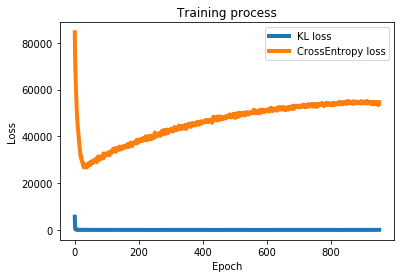

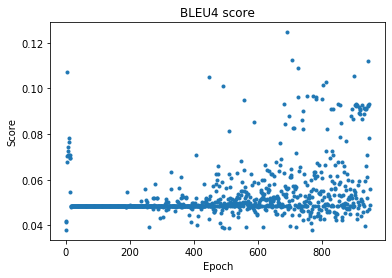

0      0.0
1      0.2
2      0.4
3      0.6
4      0.8
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     0.0
11     0.2
12     0.4
13     0.6
14     0.8
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     0.0
21     0.2
22     0.4
23     0.6
24     0.8
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
922    0.4
923    0.6
924    0.8
925    1.0
926    1.0
927    1.0
928    1.0
929    1.0
930    0.0
931    0.2
932    0.4
933    0.6
934    0.8
935    1.0
936    1.0
937    1.0
938    1.0
939    1.0
940    0.0
941    0.2
942    0.4
943    0.6
944    0.8
945    1.0
946    1.0
947    1.0
948    1.0
949    1.0
950    0.0
951    0.2
Name: klw, Length: 952, dtype: float64


In [212]:
def plot_result(df):
   
    plt.subplots(1)
    plt.title('Training process')
    plt.plot(df.index, df.kl, label='KL loss', linewidth=4)
    plt.plot(df.index, df.crossentropy, label='CrossEntropy loss', linewidth=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(('KL loss', 'CrossEntropy loss'),loc='upper right')
    plt.subplots(1)
    plt.title('BLEU4 score')
    plt.plot(metrics_df.index, metrics_df.score, '.', label='BLEU4 score')
    #plt.plot(metrics_df.index, metrics_df.klw, label='KL weight')
    #plt.plot(metrics_df.index, metrics_df.tfr, '--', label='Tracher forcing ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()
plot_result(metrics_df)
print(metrics_df.klw,)

In [114]:
evaluation(encoder, decoder, test_dataset)

abandon -> abandoned : abandoned
abet -> abetting : abasing
begin -> begins : begins
expend -> expends : owes
sent -> sends : sents
split -> splitting : splitting
flared -> flare : flare
functioning -> function : function
functioning -> functioned : functioned
healing -> heals : heals
BLEU-4 score : 0.7509077287947072


In [194]:
evaluation(encoder, decoder, test_dataset)

abandon -> abandoned : boerered
abet -> abetting : boerering
begin -> begins : boessws
expend -> expends : boessws
sent -> sends : boeh
split -> splitting : borhceigg
flared -> flare : boerer
functioning -> function : boerer
functioning -> functioned : boerere
healing -> heals : boessws
BLEU-4 score : 0.05507959219588354


[0.06164542728425844,
 0.13485111859503685,
 0.043472087194499145,
 0.039281465090051315,
 0.06257106818159155,
 0.028517539529041507,
 0.08633400213704504,
 0.02925226826055808,
 0.02558948059670209,
 0.039281465090051315]

In [158]:
def generate_word(encoder, decoder, z, condition, maxlen=20):
    encoder.eval()
    decoder.eval()
    
    outputs = decode_teaching(
        decoder, z, encoder.condition(condition), maxlen=maxlen
    )
    return torch.max(torch.softmax(outputs, dim=1), 1)[1]

def Gaussian_score(words):
    words_list = []
    score = 0
    yourpath = 'C:\\Users\\tingyang\\LAB3\\train.txt'
    with open(yourpath,'r') as fp:
        for line in fp:
            word = line.split(' ')
            word[3] = word[3].strip('\n')
            words_list.extend([word])
        for t in words:
            for i in words_list:
                if t == i:
                    score += 1
    return score/len(words)


In [159]:
words = []
for i in range(100):
    noise = encoder.sample_z()
    s = []
    for j in range(4):
        outputs = generate_word(encoder, decoder, noise, j)
        output_str = train_dataset.chardict.stringFromLongtensor(outputs)
        s.append(output_str)
    words.append(s)
print(words)
print(Gaussian_score(words))

[['embaaaa', 'embasains', 'embasaining', 'embasailed'], ['swit', 'swits', 'switcing', 'switcd'], ['regot', 'regots', 'regotting', 'regot'], ['burst', 'bursts', 'bursting', 'burst'], ['succe', 'succes', 'succsing', 'succeed'], ['bewail', 'bewails', 'bewailing', 'bewail'], ['wen', 'wents', 'wenting', 'went'], ['swing', 'singles', 'singling', 'singled'], ['festoon', 'reseots', 'festooning', 'festooned'], ['yell', 'yells', 'yelling', 'yeld'], ['surgi', 'survises', 'surving', 'surgived'], ['tell', 'tells', 'telling', 'telled'], ['swish', 'swishes', 'swishing', 'switched'], ['still', 'stiffs', 'stilling', 'stiched'], ['understand', 'undersses', 'undergoing', 'underseed'], ['truggle', 'tiggees', 'truggling', 'truggled'], ['wea', 'weads', 'wealing', 'wead'], ['sulk', 'sulks', 'sulking', 'sulked'], ['rade', 'rades', 'rading', 'rade'], ['whecy', 'whects', 'whesting', 'whelped'], ['seek', 'seeks', 'senking', 'swuwhed'], ['stot', 'stotes', 'streting', 'stote'], ['stitu', 'stitus', 'stituting', 'st

In [195]:
words = []
for i in range(100):
    noise = encoder.sample_z()
    s = []
    for j in range(4):
        outputs = generate_word(encoder, decoder, noise, j)
        output_str = train_dataset.chardict.stringFromLongtensor(outputs)
        s.append(output_str)
    words.append(s)
print(words)
print(Gaussian_score(words))

[['boerer', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boerses', 'borhceigg', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boeh', 'borhceigg', 'boerere'], ['boerer', 'boeh', 'borhceigg', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boeh', 'boeh', 'boerering', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boeh', 'boessws', 'borhceigg', 'boerered'], ['boeh', 'boeh', 'borhceigg', 'boerered'], ['boeh', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boeh', 'borhceigg', 'boerere'], ['boerer', 'boerses', 'borhceigg', 'boerere'], ['boeh', 'boeh', 'borhceigg', 'boerered'], ['boerer', 'boessws', 'borhceigg', 'boerered'], ['boerer', 'boeh', 'borhceigg', 'boerered'], ['boerer', 'boerers', 'boerering', 'boerere'], ['boerer', 'boerers', 'borhcegng', 'boerered'], ['boeh', 'boeh', 'borhceigg', 'boerere'], ['boerer', 'boeh', 'borhceigg', 

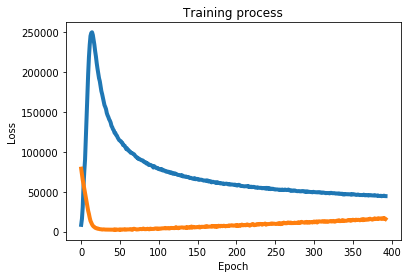

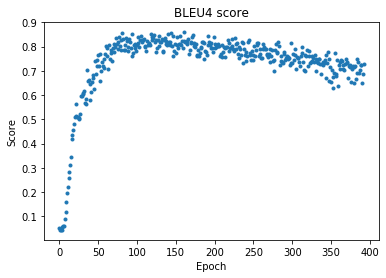

In [196]:
def plot_result(df):
   
    plt.subplots(1)
    plt.title('Training process')
    plt.plot(df.index, df.kl, label='KL loss', linewidth=4)
    plt.plot(df.index, df.crossentropy, label='CrossEntropy loss', linewidth=4)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplots(1)
    plt.title('BLEU4 score')
    plt.plot(metrics_df.index, metrics_df.score, '.', label='BLEU4 score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()
plot_result(metrics_df)

# Demo 

In [215]:
load_model(
    {'encoder':encoder, 'decoder':decoder}, 
    os.path.join('.', 'result')
)

evaluation(encoder, decoder, test_dataset)
words = []
for i in range(100):
    noise = encoder.sample_z()
    s = []
    for j in range(4):
        outputs = generate_word(encoder, decoder, noise, j)
        output_str = train_dataset.chardict.stringFromLongtensor(outputs)
        s.append(output_str)
    words.append(s)
print(words)
print(Gaussian_score(words))

abandon -> abandoned : abandoned
abet -> abetting : abetting
begin -> begins : begins
expend -> expends : expends
sent -> sends : sents
split -> splitting : spliting
flared -> flare : flare
functioning -> function : function
functioning -> functioned : functionaliz
healing -> heals : heals
BLEU-4 score : 0.8641062266884308
[['fixe', 'fixes', 'fixed', 'fixed'], ['prokes', 'prokess', 'sproking', 'sproked'], ['score', 'scores', 'scorving', 'sooteed'], ['fortigh', 'fortights', 'fortighing', 'fortighted'], ['asserve', 'asserves', 'asserving', 'asserved'], ['bestow', 'bestows', 'bestowing', 'bestowed'], ['boll', 'bolls', 'bolling', 'bolled'], ['intshive', 'filish', 'fitching', 'fitshed'], ['broze', 'brozzes', 'brozzing', 'brozzed'], ['gast', 'gasts', 'gasting', 'gastened'], ['igvanize', 'imbraces', 'igvanizing', 'igvanized'], ['falter', 'falters', 'faltinging', 'faltracted'], ['gotser', 'gotserms', 'gostening', 'gostended'], ['gatin', 'gating', 'gating', 'gating'], ['wield', 'wields', 'wield